In [52]:
import pathlib
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.regularizers import l2
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

data_dir = "/home/pei/Documents/yi_liu/graph2vec/CNN/data_process"
data_dir = pathlib.Path(data_dir)
data_dir1 = "/home/pei/Documents/yi_liu/graph2vec/CNN/data_process/1"
data_dir1 = pathlib.Path(data_dir1)
data_dir2 = "/home/pei/Documents/yi_liu/graph2vec/CNN/data_process/2"
data_dir2 = pathlib.Path(data_dir2)
data_dir3 = "/home/pei/Documents/yi_liu/graph2vec/CNN/data_process/3"
data_dir3 = pathlib.Path(data_dir3)
image_count = len(list(data_dir.glob('*/*.png')))
image_count1 = len(list(data_dir1.glob('*.png')))
image_count2 = len(list(data_dir2.glob('*.png')))
image_count3 = len(list(data_dir3.glob('*.png')))

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
list_ds1 = tf.data.Dataset.list_files(str(data_dir1/'*'), shuffle=False)
list_ds1 = list_ds1.shuffle(image_count1, reshuffle_each_iteration=False)
list_ds2 = tf.data.Dataset.list_files(str(data_dir2/'*'), shuffle=False)
list_ds2 = list_ds2.shuffle(image_count2, reshuffle_each_iteration=False)
list_ds3 = tf.data.Dataset.list_files(str(data_dir3/'*'), shuffle=False)
list_ds3 = list_ds3.shuffle(image_count3, reshuffle_each_iteration=False)
# list_ds4 = list_ds1.concatenate(list_ds2)

In [53]:
for f in list_ds1.take(5):
    print(f.numpy())
for item in data_dir.glob('*'):
    print(item.name)

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if len(item.name) == 1]))
print(class_names)

b'/home/pei/Documents/yi_liu/graph2vec/CNN/data_process/1/122_1.png'
b'/home/pei/Documents/yi_liu/graph2vec/CNN/data_process/1/1172.png'
b'/home/pei/Documents/yi_liu/graph2vec/CNN/data_process/1/1250.png'
b'/home/pei/Documents/yi_liu/graph2vec/CNN/data_process/1/22.png'
b'/home/pei/Documents/yi_liu/graph2vec/CNN/data_process/1/1020.png'
1
3
2
._.DS_Store
image2array.py
.DS_Store
._image2array.py
['1' '2' '3']


In [54]:
batch_size = 26
img_height = 250
img_width = 250

# train_size = int(0.7 * DATASET_SIZE)
# val_size = int(0.15 * DATASET_SIZE)
# test_size = int(0.15 * DATASET_SIZE)
# full_dataset = tf.data.TFRecordDataset(FLAGS.input_file)
# full_dataset = full_dataset.shuffle()
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

train_size1 = int(image_count1 * 0.8)
train_size2 = int(image_count2 * 0.8)
train_size3 = int(image_count3 * 0.8)
train_size = train_size1 + train_size2 + train_size3

test_size1 = int(image_count1 * 0.2)
test_size2 = int(image_count2 * 0.2)
test_size3 = int(image_count3 * 0.2)
test_size = test_size1 + test_size2 + test_size3

val_size1 = int(train_size1 * 0.2)
val_size2 = int(train_size2 * 0.2)
val_size3 = int(train_size3 * 0.2)
val_size = val_size1 + val_size2 + val_size3

train_ds1 = list_ds1.take(train_size1)
test_ds1 = list_ds1.skip(train_size1)
val_ds1 = train_ds1.take(val_size1)
train_ds1 = train_ds1.skip(val_size1)

train_ds2 = list_ds2.take(train_size2)
test_ds2 = list_ds2.skip(train_size2)
val_ds2 = train_ds2.take(val_size2)
train_ds2 = train_ds2.skip(val_size2)

train_ds3 = list_ds3.take(train_size3)
test_ds3 = list_ds3.skip(train_size3)
val_ds3 = train_ds3.take(val_size3)
train_ds3 = train_ds3.skip(val_size3)

train_ds = train_ds1.concatenate(train_ds2.concatenate(train_ds3))
train_ds = train_ds.shuffle(train_size, reshuffle_each_iteration=False)
val_ds = val_ds1.concatenate(val_ds2.concatenate(val_ds3))
val_ds = val_ds.shuffle(test_size, reshuffle_each_iteration=False)
test_ds = test_ds1.concatenate(test_ds2.concatenate(test_ds3))
test_ds = test_ds.shuffle(val_size, reshuffle_each_iteration=False)

print(tf.data.experimental.cardinality(train_ds1).numpy())
print(tf.data.experimental.cardinality(val_ds1).numpy())

993
248


In [55]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)

  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

Image shape:  (250, 250, 3)
Label:  0
Image shape:  (250, 250, 3)
Label:  1
Image shape:  (250, 250, 3)
Label:  1
Image shape:  (250, 250, 3)
Label:  2
Image shape:  (250, 250, 3)
Label:  0


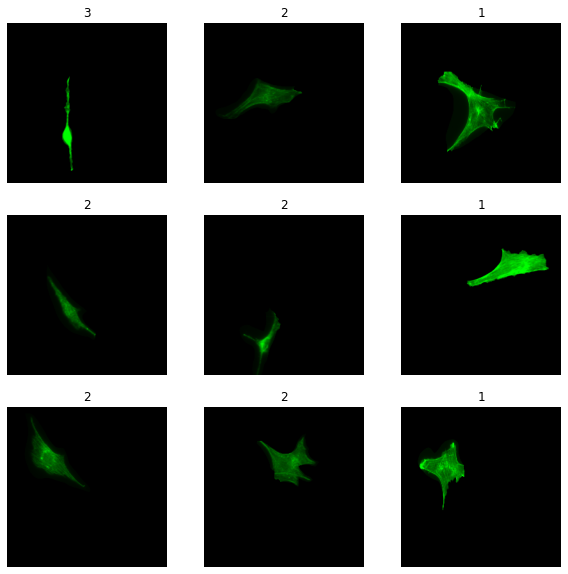

In [56]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [57]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, kernel_regularizer=l2(0.01), activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, kernel_regularizer=l2(0.01), activation='softmax')
])

In [60]:
model.compile(
  optimizer='adam',
#   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = 5
)

Epoch 1/5
101/101 [==============================] - 6s 51ms/step - loss: 0.9938 - accuracy: 0.6451 - val_loss: 0.9185 - val_accuracy: 0.7053
Epoch 2/5
101/101 [==============================] - 203s 2s/step - loss: 0.9549 - accuracy: 0.6809 - val_loss: 0.9504 - val_accuracy: 0.6947
Epoch 3/5
101/101 [==============================] - 5s 45ms/step - loss: 0.9542 - accuracy: 0.6859 - val_loss: 0.9342 - val_accuracy: 0.7282
Epoch 4/5
101/101 [==============================] - 5s 45ms/step - loss: 0.9211 - accuracy: 0.7022 - val_loss: 0.9751 - val_accuracy: 0.6947
Epoch 5/5
101/101 [==============================] - 5s 45ms/step - loss: 0.9242 - accuracy: 0.7091 - val_loss: 0.9238 - val_accuracy: 0.7084


In [61]:
y_pred = model.predict(test_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

model.evaluate(test_ds)
confusion_matrix(predicted_categories, true_categories)
classification_report(predicted_categories, true_categories)

32/32 [==============================] - 1s 17ms/step - loss: 0.9151 - accuracy: 0.6894


'              precision    recall  f1-score   support\n\n           0       0.27      0.35      0.30       241\n           1       0.53      0.34      0.41       445\n           2       0.12      0.21      0.16       135\n\n    accuracy                           0.32       821\n   macro avg       0.31      0.30      0.29       821\nweighted avg       0.39      0.32      0.34       821\n'